<a href="https://colab.research.google.com/github/sindhupadam/sindhu/blob/main/DR_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm

import scipy
from math import sqrt,pi
from numpy import exp

from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os

# Specify the directory containing the images
directory = '/content/drive/MyDrive/d'

# Get the list of image files in the directory
image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]

immatrix = []

# Loop through each image file
for img_pt in image_files:
    img = cv2.imread(img_pt)

    # Check if the image is not None
    if img is not None:
        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize the image to (200, 200) if needed
        img_resized = cv2.resize(img_gray, (200, 200))

        # Equalize the histogram
        equ = cv2.equalizeHist(img_resized)

        # Flatten the image and append to the immatrix
        immatrix.append(np.array(equ).flatten())
    else:
        print(f"Could not read image: {img_pt}")

# Check if any images were successfully loaded
if not immatrix:
    print("No valid images found.")


In [ ]:
np.shape(equ)

(200, 200)

In [ ]:
np.shape(np.array(equ).flatten())

(40000,)

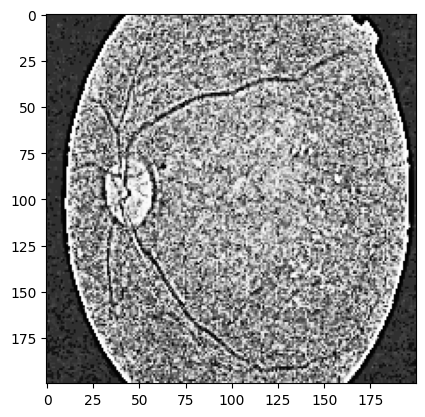

In [ ]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[5].reshape((200,200)),cmap='gray')
plt.show()

In [ ]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((200,200))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

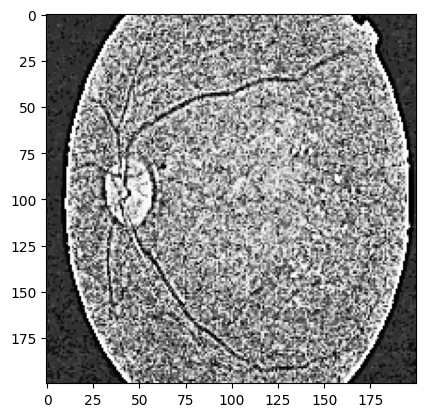

In [ ]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[5].reshape((200,200)),cmap='gray')
plt.show()

In [ ]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')

    ctr_x = dim_x / 2
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate.
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1)

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((200,200))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())

In [ ]:
np.shape(imm_gauss)
plt.imshow(imm_gauss[8].reshape((200,200)),cmap='gray')
plt.show()

In [ ]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((200,200))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())

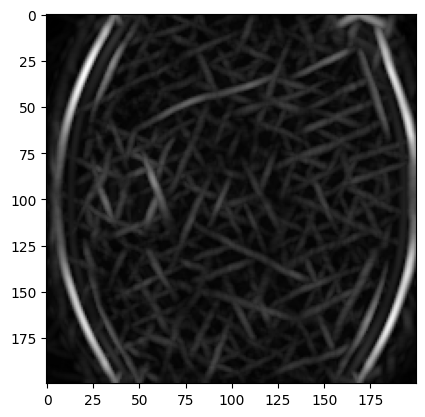

In [ ]:
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[5].reshape((200,200)),cmap='gray')
plt.show()

In [ ]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,2))
np.shape(e_)

(20000, 2)

In [ ]:
img = equ3
Z = img.reshape((-1,2))

# # convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [ ]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((200,200))
    Z = img.reshape((-1,2))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())

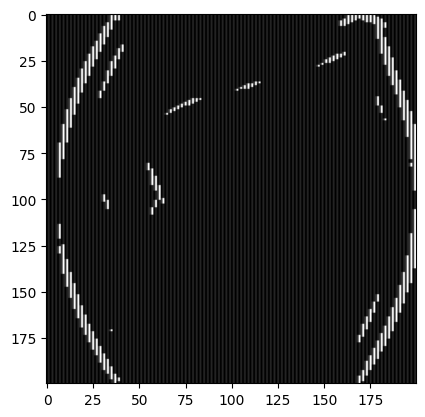

In [ ]:
np.shape(imm_kmean)
plt.imshow(imm_kmean[5].reshape((200,200)),cmap="gray")
plt.show()

In [ ]:
from sklearn.svm import SVC
clf = SVC()

In [ ]:
Y = np.ones(18)

In [ ]:
Y[1]=Y[5]=Y[7]=Y[17]=Y[6]=0

In [ ]:
clf.fit(imm_kmean, Y,sample_weight=np.ones(len(Y)))

SVC()

In [ ]:
k = [1,3,4,9,10,11,13,14,17]

In [ ]:
k = k-np.ones(len(k))
k

array([ 0.,  2.,  3.,  8.,  9., 10., 12., 13., 16.])

In [ ]:
k =[int(x) for x in k]
k

[0, 2, 3, 8, 9, 10, 12, 13, 16]

In [ ]:
imm_train = []
y_train = []
k.append(5)
k.append(7)
for i in k:
    imm_train.append(imm_kmean[i])
    y_train.append(Y[i])

In [ ]:
y_train

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]

In [ ]:
clf.fit(imm_train, y_train)

SVC()

In [ ]:
y_pred = clf.predict(imm_kmean)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y,y_pred)

0.7222222222222222

In [3]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv(r'/content/drive/MyDrive/train (1).csv')

In [9]:
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)

In [11]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

In [12]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [13]:
!pip install kaggle

In [14]:
! mkdir ~/.kaggle

In [15]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [16]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [17]:
! chmod 600 ~/.kaggle/kaggle.json

In [18]:
! kaggle datasets download sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

 98% 417M/427M [00:04<00:00, 86.4MB/s]
100% 427M/427M [00:04<00:00, 102MB/s] 


In [ ]:
!unzip '/content/diabetic-retinopathy-224x224-gaussian-filtered.zip'

In [20]:
src_dir = r'//content/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile3 = os.path.join(src_dir, diagnosis, id_code)
    dstfile3= os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile3, exist_ok = True)
    shutil.copy(srcfile3, dstfile3)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [21]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [22]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=2,
                    validation_data=val_batches)

Epoch 1/2
81/81 [==============================] - 131s 2s/step - loss: 0.3205 - acc: 0.8868 - val_loss: 0.7699 - val_acc: 0.5073
Epoch 2/2
81/81 [==============================] - 112s 1s/step - loss: 0.2067 - acc: 0.9309 - val_loss: 0.7463 - val_acc: 0.5073


In [23]:
model.save('64x3-CNN.model')

In [24]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-24-b08fd55361be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 9s 471ms/step - loss: 0.7381 - acc: 0.5073
Loss:  0.7380928993225098
Accuracy:  0.5072727203369141


In [25]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('Diabetic Retinopathy Not Detected')
    else:
        print('Diabetic Retinopathy Detected')

1/1 [==============================] - 0s 177ms/step
Diabetic Retinopathy Detected


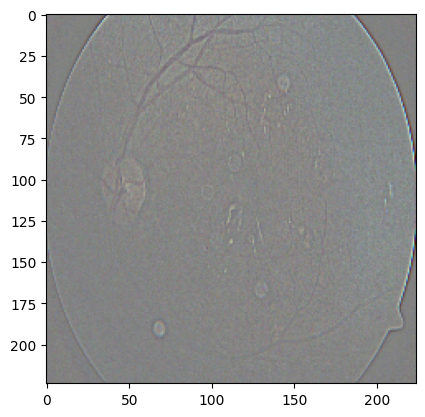

In [26]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Moderate/00b74780d31d.png')

1/1 [==============================] - 0s 307ms/step
Diabetic Retinopathy Detected


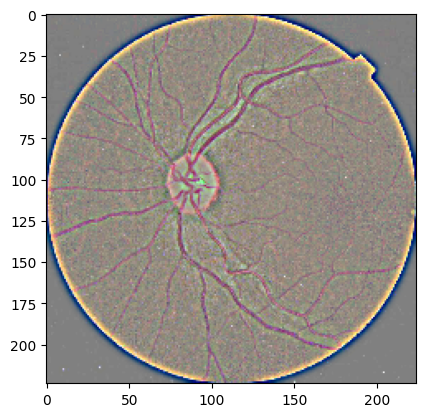

In [27]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR/00f6c1be5a33.png')

1/1 [==============================] - 1s 513ms/step
Diabetic Retinopathy Detected


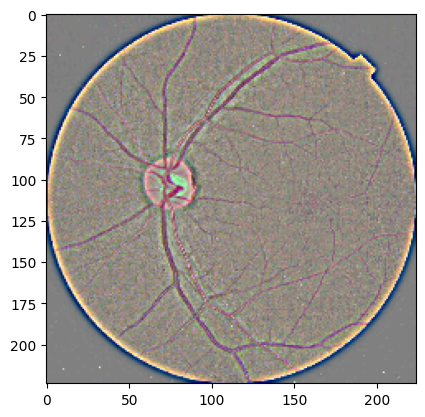

In [29]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR/0212dd31f623.png')

1/1 [==============================] - 0s 343ms/step
Diabetic Retinopathy Detected


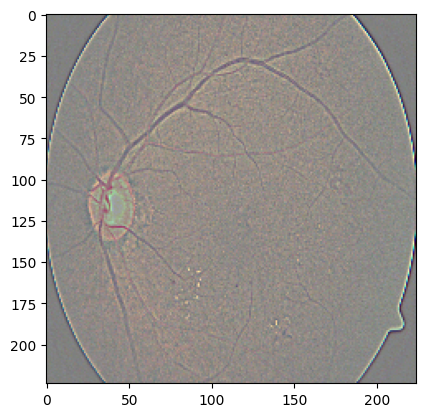

In [30]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0318598cfd16.png')